Enterprises often have multiple data scientists working on the similar data, and their code is usually checked into a central repository such as GitHub.  SemForms mines such a repository of code manipulating various datasets to mine what other data scientists have done with similar datasets.

As an example, let us assume that a data scientist wants to analyze a dataset with house price information.

In [16]:
import pandas
df = pandas.read_csv('/data/openml_rawds/houses.csv')
df

,Unnamed: 0,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,binaryClass
0,0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,0
1,1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,0
2,2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,0
3,3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,0
4,4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,0
...,...,...,...,...,...,...,...,...,...,...
20635,20635,78100.0,1.5603,25.0,1665.0,374.0,845.0,330.0,39.48,0
20636,20636,77100.0,2.5568,18.0,697.0,150.0,356.0,114.0,39.49,0
20637,20637,92300.0,1.7000,17.0,2254.0,485.0,1007.0,433.0,39.43,0
20638,20638,84700.0,1.8672,18.0,1860.0,409.0,741.0,349.0,39.43,0


Then, the scientist might want to query any other manipulations that have been performed on similar data by other data scientists in the organization.  SemForms is an index built by mining all such manipulations for over 100 datasets on 100K Python notebooks.  The code below queries the index with a dataset URL and a target that might be interesting to the data scientist.  The API returns the transforms applied by various data scientists in an executable form; i.e., as lambda functions.  These can be used to transform the data frame if it seems useful.

In [17]:
import requests
import json
response = requests.get('http://expressions.sl.cloud9.ibm.com:8000/expressions/?dataset_url=houses.csv&target=median_house_value')
response.json()

[{'expression': "lambda df: (df[ 'total_bedrooms' ] / df[ 'total_rooms' ])"},
 {'expression': "lambda df: (df[ 'total_rooms' ] / df[ 'population' ])"},
 {'expression': "lambda df: (df[ 'total_rooms' ] / df[ 'households' ])"},
 {'expression': "lambda df: (df[ 'total_bedrooms' ] / df[ 'households' ])"},
 {'expression': "lambda df: (df[ 'population' ] / df[ 'households' ])"}]

Let's take one of the expressions returned which suggests that the ratio of square footage taken up by bedrooms compared to all the rooms is somehow useful to predict house price, and add it in as a column.

In [18]:
df['expr1'] = (df[ 'total_bedrooms' ] / df[ 'total_rooms' ])
df

,Unnamed: 0,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,binaryClass,expr1
0,0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,0,0.146591
1,1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,0,0.155797
2,2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,0,0.129516
3,3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,0,0.184458
4,4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,0,0.172096
...,...,...,...,...,...,...,...,...,...,...,...
20635,20635,78100.0,1.5603,25.0,1665.0,374.0,845.0,330.0,39.48,0,0.224625
20636,20636,77100.0,2.5568,18.0,697.0,150.0,356.0,114.0,39.49,0,0.215208
20637,20637,92300.0,1.7000,17.0,2254.0,485.0,1007.0,433.0,39.43,0,0.215173
20638,20638,84700.0,1.8672,18.0,1860.0,409.0,741.0,349.0,39.43,0,0.219892


Is that useful to predict the median house value?  We can check by computing a Pearson r correlation.  As you can see, it is correlated negatively - meaning the smaller the ratio the larger the house price, which makes sense.  The corrlation is -0.25, and the likelihood that this is purely due to chance is very small (3.12e-305).

In [19]:
from scipy.stats import pearsonr
pearsonr(df['expr1'], df['median_house_value'])

(-0.2556241671955807, 3.118689311524638e-305)

A scatterplot is a visual way to look at the relationship.  All other expressions returned by the API call above are also statistically related to the target.

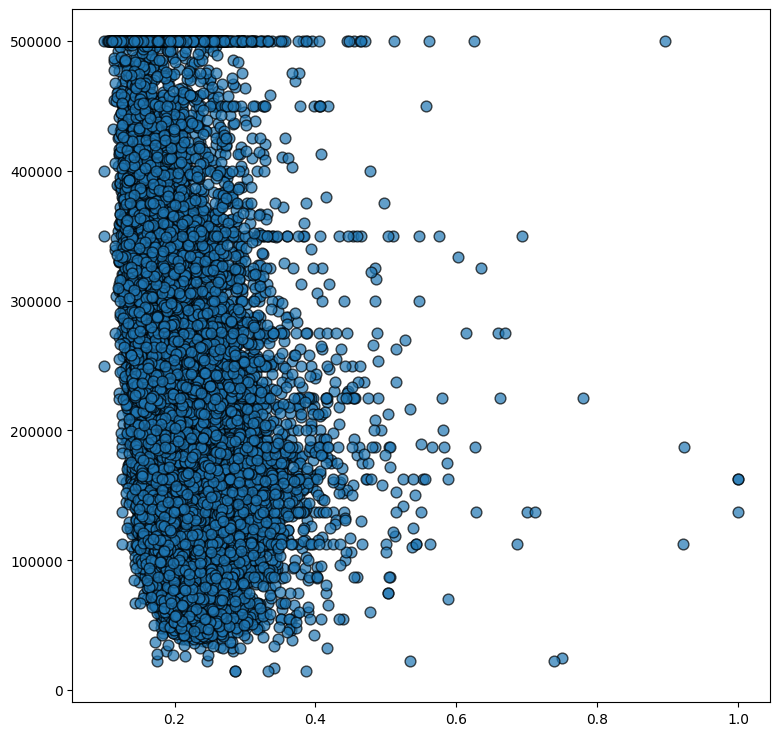

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

# Add scatterplot
ax.scatter(df['expr1'], df['median_house_value'], s=60, alpha=0.7, edgecolors="k")
